In [1]:
using Convex
using SCS # I think I fixed it
#using ECOS
using Plots
using LinearAlgebra

In [2]:
gr()
include("plotregion.jl")

Main.PlotRegion

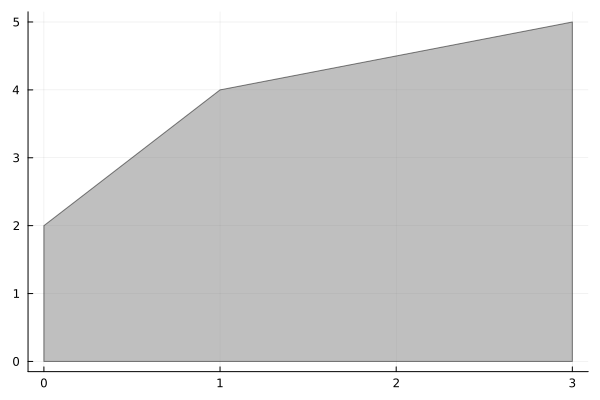

In [3]:
A1 = [-2.0 1; 
      -1 2; 
       1 0]
b = [2.0; 7; 3]

A = [A1 Matrix{Float64}(I,3,3)] # form the problem with slacks.

PlotRegion.plotregion(A,b)

In [4]:
# Convert the problem into standard form.
cs = [-1 -2 0 0 0]'
AS = A

3×5 Matrix{Float64}:
 -2.0  1.0  1.0  0.0  0.0
 -1.0  2.0  0.0  1.0  0.0
  1.0  0.0  0.0  0.0  1.0

In [5]:
""" Solve the central-path problem for interior point methods. """
function ip_central(c,A,b,tau)
    x = Variable(length(c))
    constraints = Constraint[
        A*x == b
    ]
    p = minimize(c'*x - tau*sum(log(x)), constraints)
    
    solve!(p, SCS.Optimizer; silent=true)
    #solve!(p, ECOS.Optimizer; silent = true)
    return x.value, p
end
ip_central(cs,AS,b,10.0)[1]

5×1 Matrix{Float64}:
 2.1944265108421326
 2.1971437784015126
 4.191709445576553
 4.800138904383412
 0.8055738457513615

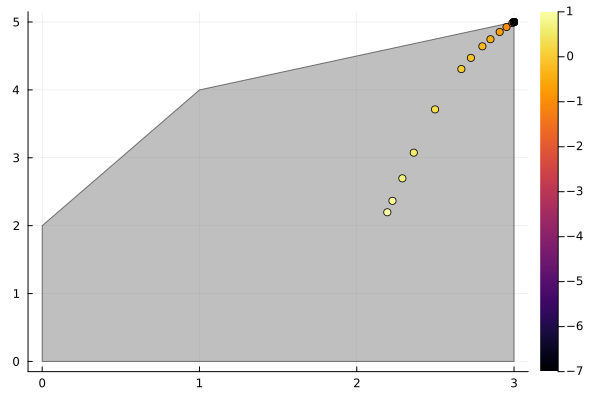

In [6]:
taus = vec([10 7.5 5 3.5 2 1 0.75 0.5 0.35 0.20 10.0.^(range(-1,stop=-7,length=10))'])

p = PlotRegion.plotregion(AS,b)
for tau in taus
    x = ip_central(cs, AS, b, tau)[1]
    scatter!([x[1]],[x[2]],label="", marker_z=log10(tau))
end
p

## Show a centered vs. uncentered step


lam = [-0.3307127844906483, -0.9507406082818322, -2.9873654286696003]


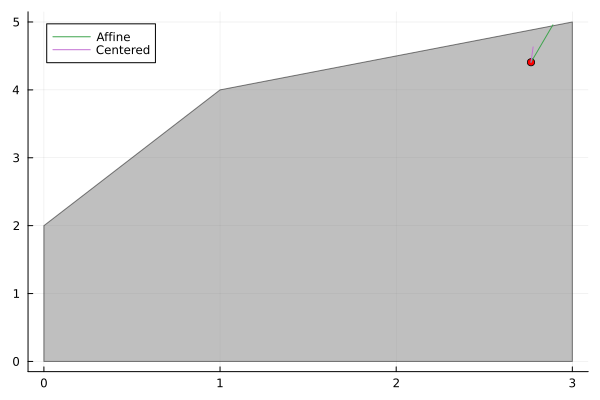

In [7]:
# Convert the problem into standard form.
cs = [-1 -2 0 0 0]'
AS = A

tau = 1
x0,prob = ip_central(cs,AS,b,tau)
x = copy(x0)
x[1] += 0.1
x[2] += 0.1

lam = vec(prob.constraints[1].dual)
@show lam

# show the region and the starting point
plt = PlotRegion.plotregion(AS,b)
scatter!([x[1]],[x[2]],label="", color="red")

# compute the steps 
n = length(cs)
m = size(AS,1)

s = tau./x
J = [zeros(n,n) AS'         Matrix{Float64}(I,n,n); 
     AS        zeros(m,m)   zeros(m,n);
    Diagonal(vec(s))  zeros(n,m) Diagonal(vec(x))]

mu = dot(x,s)/n
sigma = 0.5

F = [s + AS'*lam - cs; AS*x - b; x.*s]

Fc = [s + AS'*lam .- cs; AS*x .- b; x.*s .- sigma*mu ]

p = J\-F
pc = J\-Fc

plot!([x[1];x[1] + p[1]], [x[2];x[2] + p[2]], label="Affine")
plot!([x[1];x[1] + pc[1]], [x[2];x[2] + pc[2]], label = "Centered")

plt

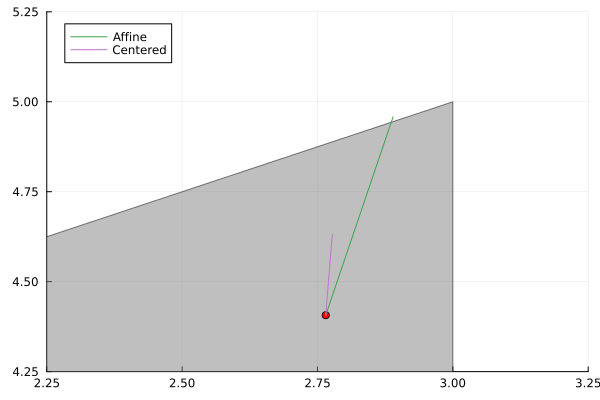

In [8]:
## Zoom in
xlims!(2.25, 3.25)
ylims!(4.25, 5.25)

In [9]:
xf = [x; lam; s];
[xf+p xf+pc]

13×2 Matrix{Float64}:
  2.88968     2.77744
  4.95809     4.63237
  2.82128     2.92251
 -0.026493    0.512692
  0.110318    0.22256
 -0.0221414  -0.176429
 -0.974733   -0.962707
 -2.00274    -2.49478
 -0.0162772   0.179219
 -0.0283924   0.101843
  0.0221414   0.176429
  0.974733    0.962707
  2.00274     2.49478

### Here we see how the centering step helps us get back on the central path

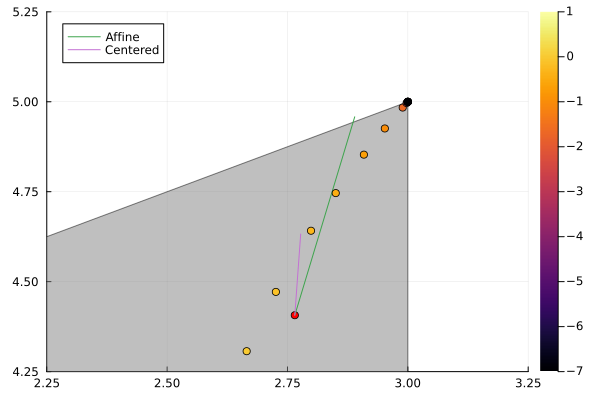

In [10]:
for tau in taus
    x = ip_central(cs, AS, b, tau)[1]
    scatter!([x[1]],[x[2]],label="", marker_z=log10(tau))
end
plt

### Let's see what happens if we are on the the central path 

lam = [-0.08443160703032893, -0.9837320066383076, -2.2391215930448882]


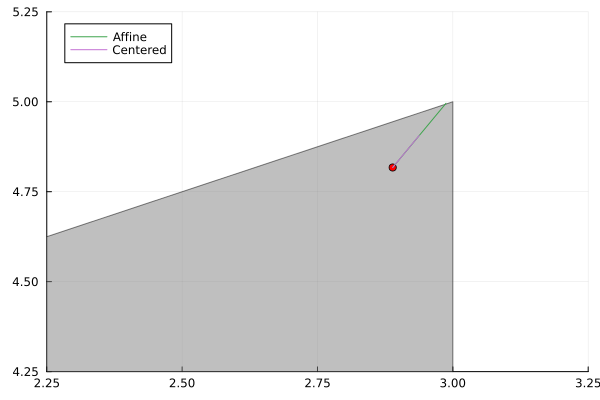

In [11]:
# Convert the problem into standard form.
cs = [-1 -2 0 0 0]'
AS = A

tau = 0.25
x0,prob = ip_central(cs,AS,b,tau)
x = copy(x0)


lam = vec(prob.constraints[1].dual)
@show lam

# show the region and the starting point
plt = PlotRegion.plotregion(AS,b)
scatter!([x[1]],[x[2]],label="", color="red")

# compute the steps 
n = length(cs)
m = size(AS,1)

s = tau./x
J = [zeros(n,n) AS'         Matrix{Float64}(I,n,n); 
     AS        zeros(m,m)   zeros(m,n);
    Diagonal(vec(s))  zeros(n,m) Diagonal(vec(x))]

mu = dot(x,s)/n
sigma = 0.5

F = [s + AS'*lam - cs; AS*x - b; x.*s]

Fc = [s + AS'*lam .- cs; AS*x .- b; x.*s .- sigma*mu ]

p = J\-F
pc = J\-Fc

plot!([x[1];x[1] + p[1]], [x[2];x[2] + p[2]], label="Affine")
plot!([x[1];x[1] + pc[1]], [x[2];x[2] + pc[2]], label = "Centered")
## Zoom in
xlims!(2.25, 3.25)
ylims!(4.25, 5.25)
plt

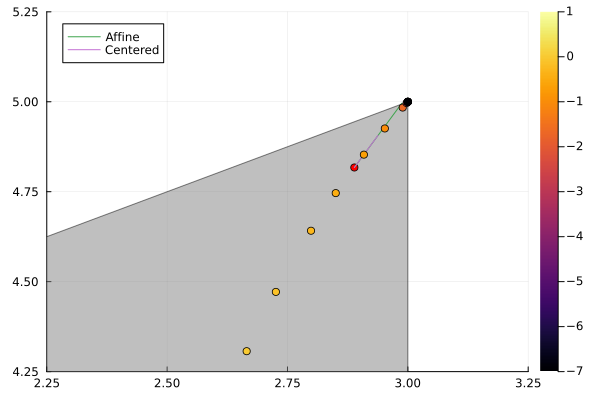

In [12]:
for tau in taus
    x = ip_central(cs, AS, b, tau)[1]
    scatter!([x[1]],[x[2]],label="", marker_z=log10(tau))
end
plt

### Let's try a point outside the area 

lam = [-0.3307127844906483, -0.9507406082818322, -2.9873654286696003]


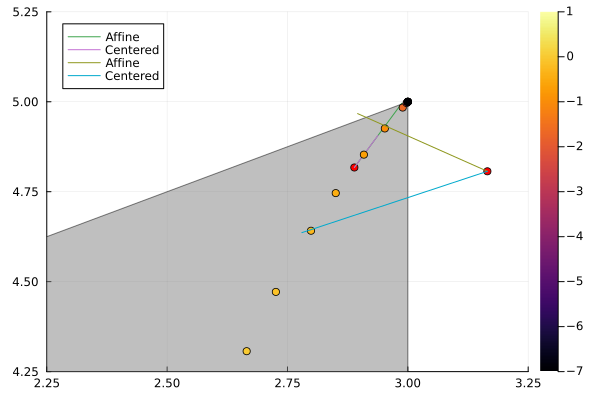

In [13]:
# Convert the problem into standard form.
cs = [-1 -2 0 0 0]'
AS = A

tau = 1
x0,prob = ip_central(cs,AS,b,tau)
x = copy(x0)
x[1] += 0.5
x[2] += 0.5

lam = vec(prob.constraints[1].dual)
@show lam

scatter!([x[1]],[x[2]],label="", color="red")

# compute the steps 
n = length(cs)
m = size(AS,1)

s = tau./x
J = [zeros(n,n) AS'         Matrix{Float64}(I,n,n); 
     AS        zeros(m,m)   zeros(m,n);
    Diagonal(vec(s))  zeros(n,m) Diagonal(vec(x))]

mu = dot(x,s)/n
sigma = 0.5

F = [s + AS'*lam - cs; AS*x - b; x.*s]

Fc = [s + AS'*lam .- cs; AS*x .- b; x.*s .- sigma*mu ]

p = J\-F
pc = J\-Fc

plot!([x[1];x[1] + p[1]], [x[2];x[2] + p[2]], label="Affine")
plot!([x[1];x[1] + pc[1]], [x[2];x[2] + pc[2]], label = "Centered")

plt